Como mencionaba en el notebook investigar correlaciones con result la columna violations merece un notebook para el solo. Traemos la data

In [5]:
import os
import pandas as pd
import boto3
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [12]:


# Configurar la conexión con S3 usando variables de entorno
load_dotenv()
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('Access_key_ID'),
    aws_secret_access_key=os.getenv('Secret_access_key')
)

bucket_name = 'chicago-inspections-analytics'
folder_prefix = 'datos_limpios/datos_limpios/'  # Ruta de la carpeta en S3

# Función para listar todos los archivos en el directorio de S3
def listar_archivos_s3(bucket_name, prefix):
    try:
        response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' in response:
            return [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.pkl')]
        return []
    except Exception as e:
        print("Error al listar archivos en S3:", e)
        return []

# Función para cargar y concatenar todos los archivos `.pkl`
def cargar_y_concatenar_pkl(bucket_name, file_keys, columnas_requeridas):
    dfs = []
    for key in file_keys:
        try:
            # Descargar el archivo de S3
            file_obj = s3_client.get_object(Bucket=bucket_name, Key=key)
            file_data = file_obj['Body'].read()
            
            # Convertir el archivo de Pickle a un DataFrame
            df = pickle.loads(file_data)
            
            # Seleccionar solo las columnas necesarias
            df = df[columnas_requeridas]
            dfs.append(df)
        except Exception as e:
            print(f"Error al cargar el archivo {key}:", e)
    
    # Concatenar todos los DataFrames
    if dfs:
        df_concatenado = pd.concat(dfs, ignore_index=True)
        print("Todos los archivos concatenados exitosamente.")
        return df_concatenado
    else:
        print("No se cargaron archivos para concatenar.")
        return None

# Columnas requeridas
columnas_requeridas = [
    'facility_type', 
    'risk', 
    'inspection_type', 
    'results', 
    'violations', 
    'latitude', 
    'longitude',
    'inspection_date',
    'inspection_id'
]

# Obtener la lista de archivos `.pkl` en el directorio
file_keys = listar_archivos_s3(bucket_name, folder_prefix)

# Cargar y concatenar los archivos
df_concatenado = cargar_y_concatenar_pkl(bucket_name, file_keys, columnas_requeridas)

# Mostrar información del DataFrame concatenado
if df_concatenado is not None:
    print("DataFrame final:")
    print(df_concatenado.head())
else:
    print("No se pudo concatenar ningún archivo.")


Error al cargar el archivo datos_limpios/datos_limpios/datos_limpios_2024-12-05_ba21bcb731f35dd4c0f3346ac1a348ec.pkl: "['violations'] not in index"
Todos los archivos concatenados exitosamente.
DataFrame final:
           facility_type           risk        inspection_type  \
0             Restaurant  Risk 1 (High)         Non-Inspection   
1  Daycare (2 - 6 Years)  Risk 1 (High)  License Re-Inspection   
2             Restaurant  Risk 1 (High)                Canvass   
3          Grocery Store   Risk 3 (Low)                License   
4         Long Term Care  Risk 1 (High)                Canvass   

           results                                         violations  \
0         No Entry                                                NaN   
1             Pass                                                NaN   
2  Out of Business                                                NaN   
3             Fail  54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...   
4             Fail  2. CITY

In [4]:
df_concatenado.head()

facility_type           risk        inspection_type  \
0             Restaurant  Risk 1 (High)         Non-Inspection   
1  Daycare (2 - 6 Years)  Risk 1 (High)  License Re-Inspection   
2             Restaurant  Risk 1 (High)                Canvass   
3          Grocery Store   Risk 3 (Low)                License   
4         Long Term Care  Risk 1 (High)                Canvass   

           results                                         violations  \
0         No Entry                                                NaN   
1             Pass                                                NaN   
2  Out of Business                                                NaN   
3             Fail  54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...   
4             Fail  2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...   

             latitude           longitude inspection_date  
0   41.91150903005694     -87.63875222616      2024-10-04  
1   41.90598597077873  -87.69680735572291      2024-10-04  
2  41.927462367666614  -87.65179320878462      2024-10-04  
3  41.886501986520884  -87.74540075402561      2024-10-04  
4  41.811989599987115  -87.74312824835363      2024-10-04

AL analizar la columna violations obsevamos una estructura algo parecida a esto
codigo
categoria
comentarios
Metadatos(aun no descifro como esta estructurado esto)

In [13]:
import pandas as pd

# Función para procesar una fila de la columna 'violations'
def procesar_violations(violations_text):
    if not isinstance(violations_text, str):  # Verifica que sea texto válido
        return []  # Retorna vacío si no es string

    violations = violations_text.split("|")  # Dividir violaciones por el delimitador
    structured_data = []

    for violation in violations:
        # Extraer cada componente usando expresiones regulares
        codigo_match = re.match(r"^\d+", violation.strip())  # Número de código al inicio
        categoria_match = re.search(r"^\d+\.\s(.+?)\s- Comments:", violation)  # Categoría
        comentarios_match = re.search(r"- Comments:(.+?)\(", violation)  # Comentarios antes del primer paréntesis
        metadatos_match = re.findall(r"\(([^)]+)\)", violation)  # Todo lo que está entre paréntesis

        # Agregar datos estructurados
        structured_data.append({
            "Código": codigo_match.group() if codigo_match else None,
            "Categoría": categoria_match.group(1).strip() if categoria_match else None,
            "Comentarios": comentarios_match.group(1).strip() if comentarios_match else None,
            "Metadatos": "; ".join(metadatos_match) if metadatos_match else None
        })

    return structured_data

# Iterar sobre cada fila y procesar
resultado = []
for _, row in df_concatenado.iterrows():
    # Procesar la columna 'violations'
    registros = procesar_violations(row.get('violations', ''))  # Maneja valores no válidos
    # Agregar inspection_id para la relación 1 a muchos
    for registro in registros:
        registro["inspection_id"] = row['inspection_id']  # Vincular con el identificador único
        resultado.append(registro)

# Convertir los resultados en un DataFrame estructurado
df_procesado = pd.DataFrame(resultado)

# Mostrar resultados
print(df_procesado.head())



  Código                                          Categoría  \
0     54  GARBAGE & REFUSE PROPERLY DISPOSED; FACILITIES...   
1     55                                               None   
2      2  CITY OF CHICAGO FOOD SERVICE SANITATION CERTIF...   
3     10                                               None   
4     16                                               None   

                                         Comentarios  \
0  OBSERVED NO COMMERCIAL DUMPSTER AVAILABLE ON P...   
1                                               None   
2  OBSERVED NO VALID CITY OF CHICAGO FOODSERVICE ...   
3  OBSERVED HANDS REMOVED FROM KITCHEN PREP AREA....   
4  OBSERVED EXCESSIVE BUILD-UP OF BLACK SLIMY MOL...   

                        Metadatos inspection_id  
0                               b       2604082  
1                            None       2604082  
2               MILK, GROUND BEEF       2604067  
3                               C       2604067  
4  ICE USED FOR HUMAN CONSUMPTION 

In [19]:
df_procesado.head()

Código                                          Categoría  \
0     54  GARBAGE & REFUSE PROPERLY DISPOSED; FACILITIES...   
1     55                                               None   
2      2  CITY OF CHICAGO FOOD SERVICE SANITATION CERTIF...   
3     10                                               None   
4     16                                               None   

                                         Comentarios  \
0  OBSERVED NO COMMERCIAL DUMPSTER AVAILABLE ON P...   
1                                               None   
2  OBSERVED NO VALID CITY OF CHICAGO FOODSERVICE ...   
3  OBSERVED HANDS REMOVED FROM KITCHEN PREP AREA....   
4  OBSERVED EXCESSIVE BUILD-UP OF BLACK SLIMY MOL...   

                        Metadatos inspection_id  
0                               b       2604082  
1                            None       2604082  
2               MILK, GROUND BEEF       2604067  
3                               C       2604067  
4  ICE USED FOR HUMAN CONSUMPTION       2604067

C:\Users\PC\AppData\Local\Temp\ipykernel_18592\1129146925.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


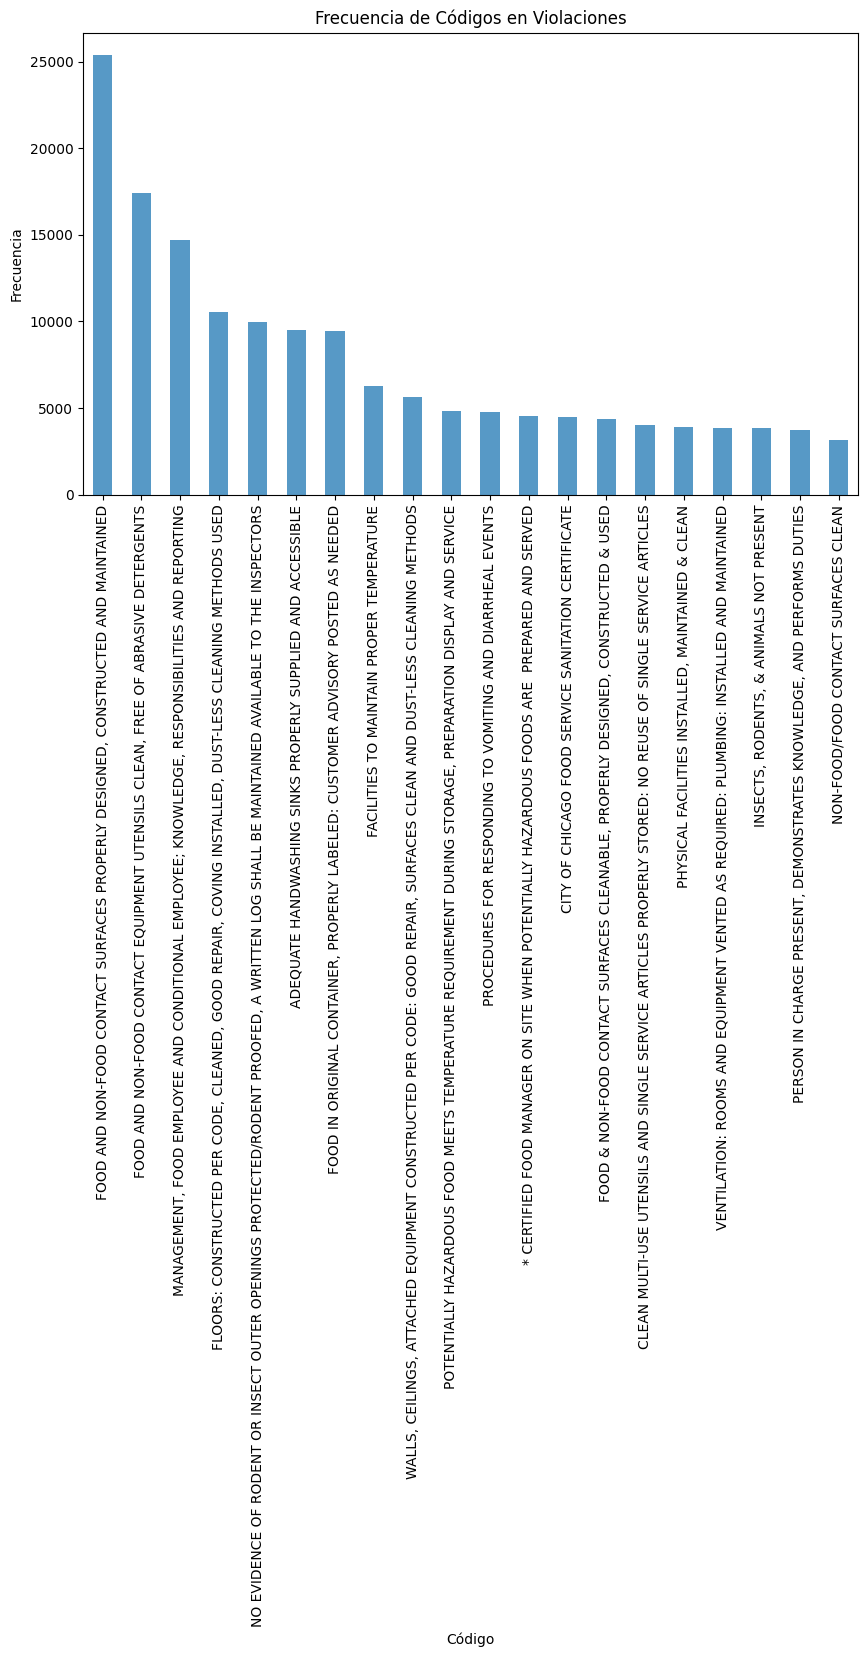

In [24]:
codigo_counts = df_procesado['Categoría'].value_counts()
top_20_codigo_counts = codigo_counts.head(20)

# Crear un histograma de los códigos
plt.figure(figsize=(10, 6))
top_20_codigo_counts.plot(kind='bar', alpha=0.75)
plt.title('Frecuencia de Códigos en Violaciones')
plt.xlabel('Código')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Ajustar el modelo a los comentarios
tfidf_matrix = vectorizer.fit_transform(df_procesado['Comentarios'].dropna())

# Obtener las palabras clave con mayor puntuación
feature_names = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1
tfidf_scores = pd.DataFrame({'Palabra': feature_names, 'TF-IDF': scores}).sort_values(by='TF-IDF', ascending=False)

# Calcular los porcentajes de TF-IDF
tfidf_scores['Porcentaje'] = (tfidf_scores['TF-IDF'] / tfidf_scores['TF-IDF'].sum()) * 100

# Mostrar las 20 palabras más relevantes con porcentaje
tfidf_scores_top_20 = tfidf_scores.head(50)

# Imprimir los resultados
print(tfidf_scores_top_20)


           Palabra       TF-IDF  Porcentaje
10460         food  6461.861390    1.480712
13733     observed  6182.524004    1.416703
7822         clean  3923.268525    0.899003
16951         sink  3771.553745    0.864238
11938   instructed  3727.134826    0.854059
10467        foods  3581.953477    0.820792
6206          area  3555.179156    0.814656
209             11  3309.393228    0.758335
11153         hand  3171.256722    0.726682
19021    violation  3038.250391    0.696204
14894         prep  3033.288040    0.695067
15197      provide  2994.839309    0.686256
12897      manager  2857.081938    0.654690
4747            38  2833.536491    0.649295
12815     maintain  2748.130126    0.629724
8420        cooler  2529.846663    0.579705
19259        water  2494.564297    0.571620
15044     priority  2492.393304    0.571123
17529      storage  2386.477672    0.546853
17994  temperature  2374.542683    0.544118
10526   foundation  2275.597395    0.521445
909             14  2258.374632 

In [32]:
from textblob import TextBlob

# Crear una función para analizar sentimientos
def analizar_sentimiento(comentario):
    blob = TextBlob(comentario)
    return blob.sentiment.polarity  # Devuelve un valor entre -1 (negativo) y 1 (positivo)

# Aplicar el análisis
df_procesado['Sentimiento'] = df_procesado['Comentarios'].dropna().apply(analizar_sentimiento)

# Mostrar los resultados
print(df_procesado[['Comentarios', 'Sentimiento']].head(10).to_string(index=False))


                                                                                                                                                                                                     Comentarios  Sentimiento
                                                                          OBSERVED NO COMMERCIAL DUMPSTER AVAILABLE ON PREMISE FOR TRASH REMOVAL. INSTRUCTED TO PROVIDE. PRIORITY FOUNDATION VIOLATION. 7-38-020     0.200000
                                                                                                                                                                                                            None          NaN
                                                                                    OBSERVED NO VALID CITY OF CHICAGO FOODSERVICE SANITATION CERTIFICATE ON SITE DURING THE PREPARATION AND SERVICE OF TCS FOODS     0.000000
OBSERVED HANDS REMOVED FROM KITCHEN PREP AREA. INSTRUCTED THE PERSON IN CHARGE THAT THE HANDWASHING SINK MUST BE

In [34]:
# Filtrar comentarios que mencionen máquinas de hielo u otros términos relacionados
palabras_clave = ['ice machine', 'mold', 'slimy', 'cube']

# Filtrar y manejar valores nulos correctamente
df_relevante = df_procesado[df_procesado['Comentarios'].fillna("").str.contains('|'.join(palabras_clave), case=False)]

# Calcular el porcentaje
porcentaje_relevante = len(df_relevante) / len(df_procesado) * 100

# Mostrar los resultados
print(f"Porcentaje de comentarios relacionados con máquinas de hielo o similares: {porcentaje_relevante:.2f}%")
print(df_relevante[['Comentarios', 'Sentimiento']].to_string(index=False))


Porcentaje de comentarios relacionados con máquinas de hielo o similares: 0.43%
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        